## Detectron2 Training

**Set the following variables, and run all.**

The notebook reports COCO eval metrics and visualizations at the end.

`img_dir`: location of all images (both training and test)

`train_json`: COCO annotation file consisting of training set annotations 

`test_json`: COCO annotation file consisting of test / validation set annotations

`dataset_name`: a name for the dataset, for detectron2 bookkeeping

In [1]:
img_dir = '/home/locobotm/AVD/habitat_turk_data/'
train_json = 'turk_annotations/habitat_train.json'
test_json = 'turk_annotations/habitat_test.json'
dataset_name = 'habitat_1'

In [11]:
import torchvision

# import some common libraries
import numpy as np
import sys
if '/opt/ros/kinetic/lib/python2.7/dist-packages' in sys.path:
    sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')

import cv2
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
import random
import os
import numpy as np
import json

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer
from detectron2.config import CfgNode as CN
from detectron2.data import DatasetCatalog, MetadataCatalog

import random
import torch 
import base64
import io
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from ast import literal_eval
from PIL import Image

pd.set_option('max_colwidth', 300)

import glob
from IPython.core.display import display, HTML

pd.set_option('max_colwidth', 300)
matplotlib.rcParams['figure.figsize'] = (20, 7.0)

display(HTML(
    """
    <style>
    .container { width:100% !important; }
    #notebook { letter-spacing: normal !important;; }
    .CodeMirror { font-family: monospace !important; }
    .cm-keyword { font-weight: bold !important; color: #008000 !important; }
    .cm-comment { font-style: italic !important; color: #408080 !important; }
    .cm-operator { font-weight: bold !important; color: #AA22FF !important; }
    .cm-number { color: #080 !important; }
    .cm-builtin { color: #008000 !important; }
    .cm-string { color: #BA2121 !important; }
    </style>
    """
))

## Detectron2 Setup

In [3]:
DatasetCatalog.clear()

train_data = dataset_name +  "_train"
val_data = dataset_name + "_val"
from detectron2.data.datasets import register_coco_instances
register_coco_instances(train_data, {}, train_json, img_dir)
register_coco_instances(val_data, {}, test_json, img_dir)

In [4]:
from detectron2.data import DatasetMapper, build_detection_train_loader

MetadataCatalog.get(train_data)

namespace(name='habitat_1_train',
          json_file='turk_annotations/habitat_train.json',
          image_root='/home/locobotm/AVD/habitat_turk_data/',
          evaluator_type='coco')

## Visualizing the dataset

[03/05 00:18:36 d2.data.datasets.coco]: Loaded 71 images in COCO format from turk_annotations/habitat_train.json


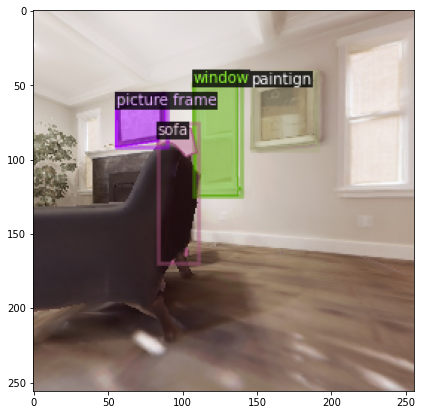

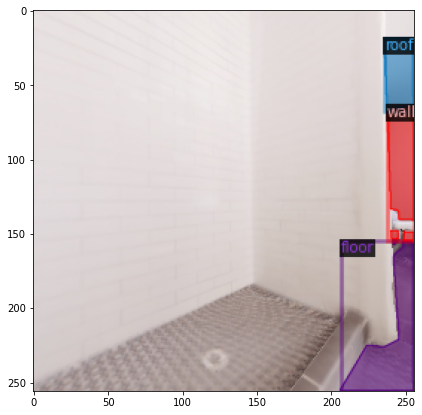

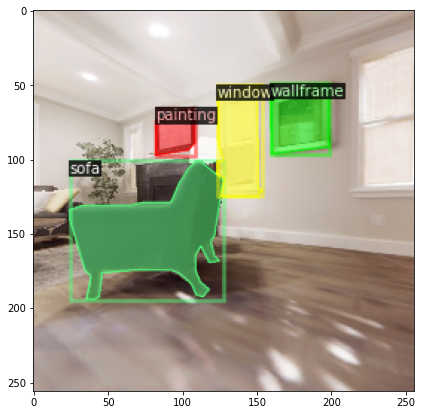

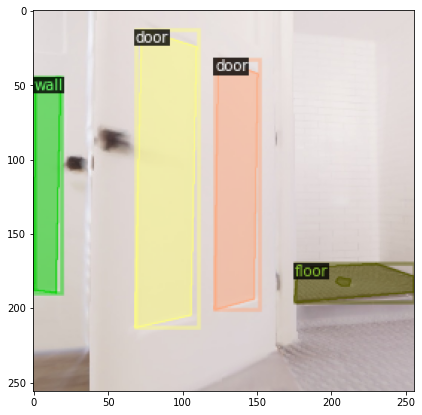

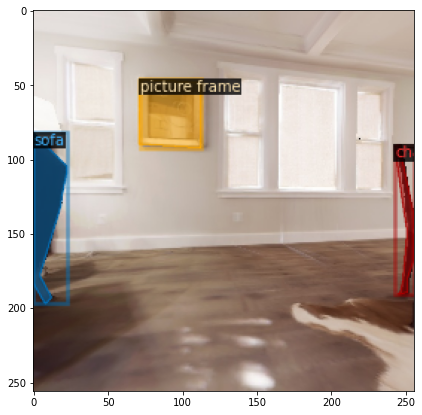

In [5]:
import random

dataset_dicts = DatasetCatalog.get(train_data)

for d in random.sample(dataset_dicts, 5):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=MetadataCatalog.get(train_data), scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    img = vis.get_image()
    plt.imshow(img)
    plt.show()

In [6]:
coco_yaml = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
lvis_yaml = "LVIS-InstanceSegmentation/mask_rcnn_R_50_FPN_1x.yaml"
lvis_yaml2 = "LVIS-InstanceSegmentation/mask_rcnn_R_101_FPN_1x.yaml"
pano_yaml = "COCO-PanopticSegmentation/panoptic_fpn_R_50_3x.yaml"

In [7]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(coco_yaml))
cfg.DATASETS.TRAIN = (train_data,)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(coco_yaml)  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.005  # pick a good LR
cfg.SOLVER.MAX_ITER = 300 
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128 
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(MetadataCatalog.get(train_data).get("thing_classes"))  # only has one class (ballon)

## Training

In [8]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

[03/05 00:18:39 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (62, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (62,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (244, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (244,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (61, 256, 1

[03/05 00:18:39 d2.engine.train_loop]: Starting training from iteration 0


/home/locobotm/anaconda3/envs/locobot_env/lib/python3.7/site-packages/detectron2/structures/masks.py:345: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629427478/work/torch/csrc/utils/python_arg_parser.cpp:766.)
  item = item.nonzero().squeeze(1).cpu().numpy().tolist()
/home/locobotm/anaconda3/envs/locobot_env/lib/python3.7/site-packages/detectron2/structures/masks.py:345: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629427478/work/torch/csrc/utils/python_arg_parser.cpp:766.)
  item = item.nonzero().squeeze(1).cpu().numpy().tolist()
/home/locobotm/anaconda3/envs/locobot_env/lib/python3.7/site-packages/detectron2/layers/wrappers.py:240: UserWarning: This overload of nonze

[03/05 00:18:44 d2.utils.events]:  eta: 0:01:00  iter: 19  total_loss: 5.489  loss_cls: 3.934  loss_box_reg: 0.6247  loss_mask: 0.6921  loss_rpn_cls: 0.1539  loss_rpn_loc: 0.02628  time: 0.2183  data_time: 0.0087  lr: 9.9905e-05  max_mem: 1868M
[03/05 00:18:48 d2.utils.events]:  eta: 0:00:59  iter: 39  total_loss: 3.362  loss_cls: 1.636  loss_box_reg: 0.7893  loss_mask: 0.6742  loss_rpn_cls: 0.1206  loss_rpn_loc: 0.01519  time: 0.2243  data_time: 0.0041  lr: 0.0001998  max_mem: 1868M
[03/05 00:18:53 d2.utils.events]:  eta: 0:00:53  iter: 59  total_loss: 2.779  loss_cls: 1.273  loss_box_reg: 0.8279  loss_mask: 0.6252  loss_rpn_cls: 0.0293  loss_rpn_loc: 0.02039  time: 0.2234  data_time: 0.0044  lr: 0.0002997  max_mem: 1868M
[03/05 00:18:57 d2.utils.events]:  eta: 0:00:48  iter: 79  total_loss: 2.702  loss_cls: 1.191  loss_box_reg: 0.9063  loss_mask: 0.5623  loss_rpn_cls: 0.0275  loss_rpn_loc: 0.01844  time: 0.2194  data_time: 0.0043  lr: 0.00039961  max_mem: 1868M
[03/05 00:19:01 d2.uti

Reusing TensorBoard on port 6006 (pid 25189), started 1:15:10 ago. (Use '!kill 25189' to kill it.)

## Evaluation

In [9]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator(val_data, ("bbox", "segm"), False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, val_data)
print(inference_on_dataset(trainer.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[03/05 00:19:49 d2.data.datasets.coco]: Loaded 18 images in COCO format from turk_annotations/habitat_test.json
[03/05 00:19:49 d2.data.build]: Distribution of instances among all 61 categories:
|   category    | #instances   |   category   | #instances   |   category    | #instances   |
|:-------------:|:-------------|:------------:|:-------------|:-------------:|:-------------|
|    window     | 10           |     door     | 15           |     chair     | 7            |
|    counter    | 2            |   cabinet    | 8            |     wall      | 1            |
|   cupboard    | 1            |   painting   | 0            |     stove     | 0            |
|    carpet     | 1            |    shower    | 0            | picture frame | 0            |
|     sofa      | 0            |  condition   | 0            |     floor     | 1            |
|   wallframe   | 0            |  dishwasher  | 0            | microwave o.. | 1            |
| cooking range | 0            |    table     | 0    

[03/05 00:19:51 d2.data.datasets.coco]: Loaded 18 images in COCO format from turk_annotations/habitat_test.json
/home/locobotm/AVD/habitat_turk_data/00000.jpg


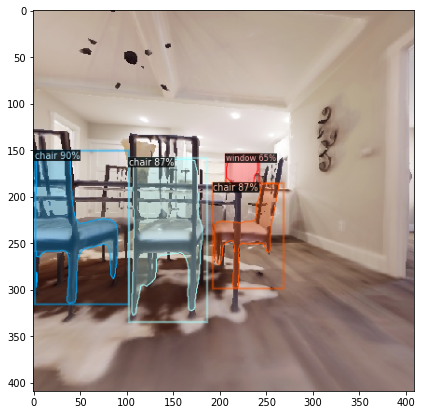

/home/locobotm/AVD/habitat_turk_data/00120.jpg


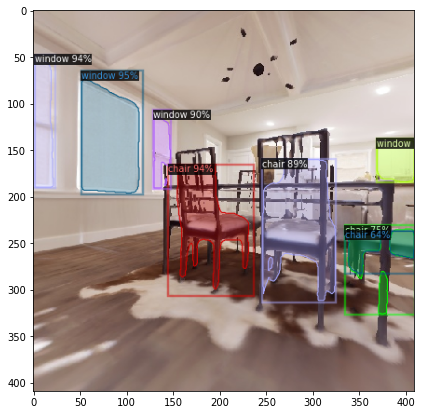

/home/locobotm/AVD/habitat_turk_data/01260.jpg


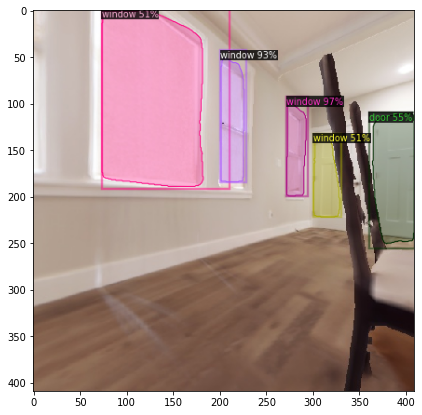

/home/locobotm/AVD/habitat_turk_data/01320.jpg


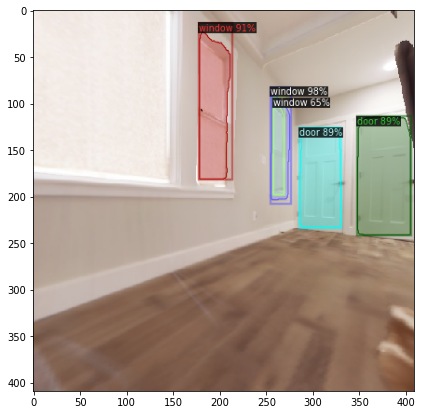

/home/locobotm/AVD/habitat_turk_data/01440.jpg


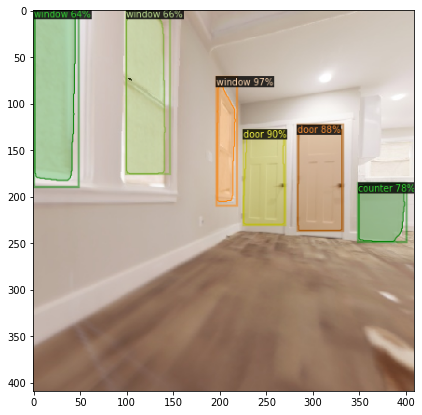

/home/locobotm/AVD/habitat_turk_data/01620.jpg


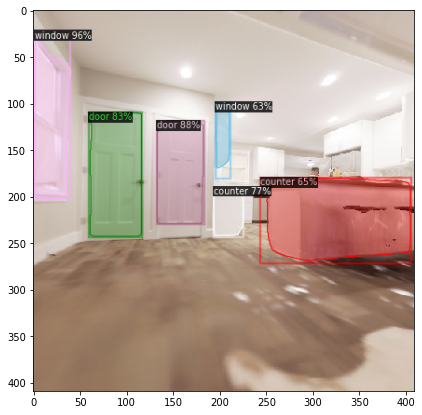

/home/locobotm/AVD/habitat_turk_data/01680.jpg


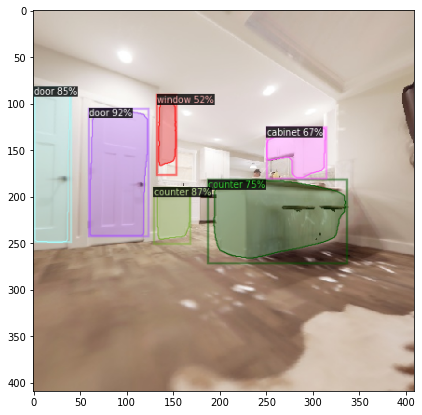

/home/locobotm/AVD/habitat_turk_data/01800.jpg


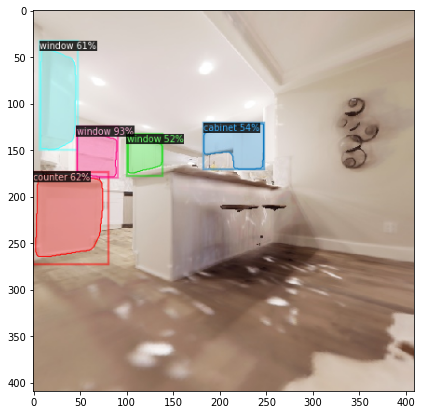

/home/locobotm/AVD/habitat_turk_data/01920.jpg


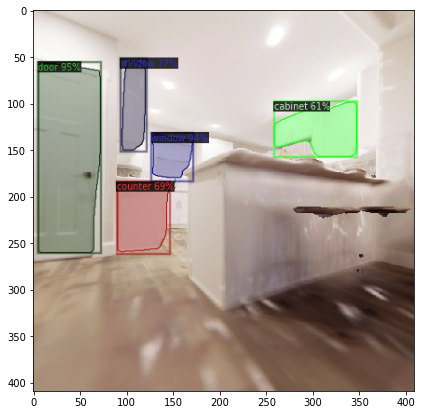

/home/locobotm/AVD/habitat_turk_data/02220.jpg


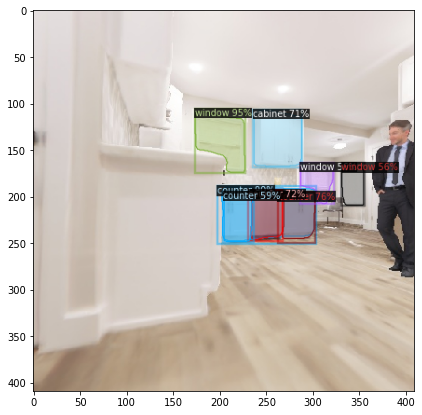

/home/locobotm/AVD/habitat_turk_data/02700.jpg


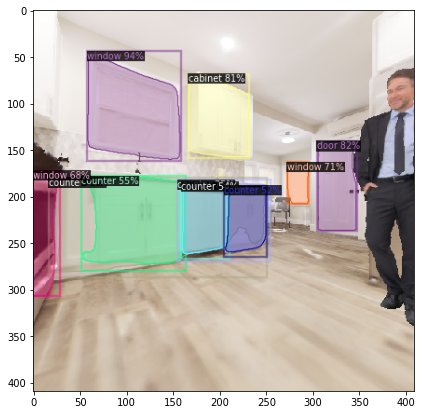

/home/locobotm/AVD/habitat_turk_data/02880.jpg


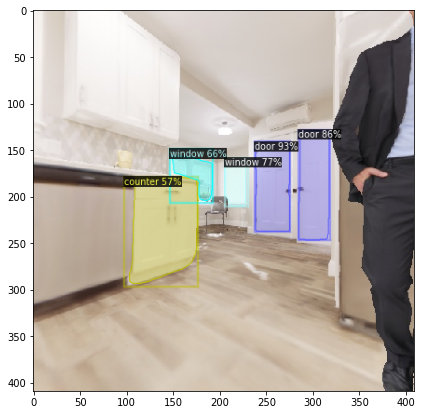

/home/locobotm/AVD/habitat_turk_data/03000.jpg


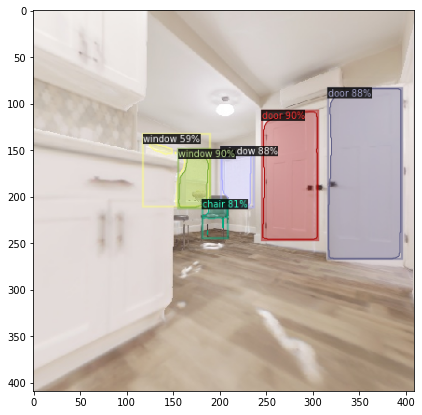

/home/locobotm/AVD/habitat_turk_data/03120.jpg


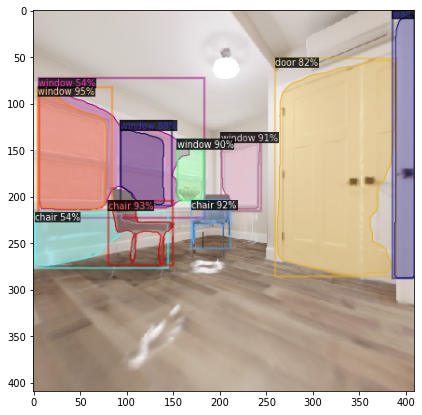

/home/locobotm/AVD/habitat_turk_data/03240.jpg


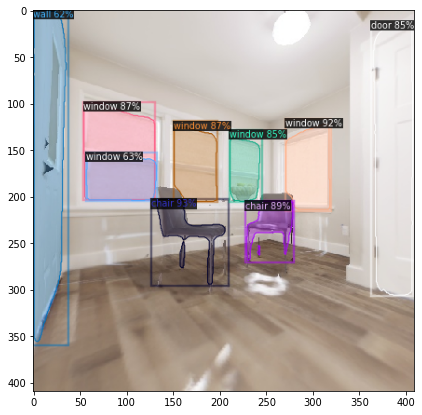

/home/locobotm/AVD/habitat_turk_data/03600.jpg


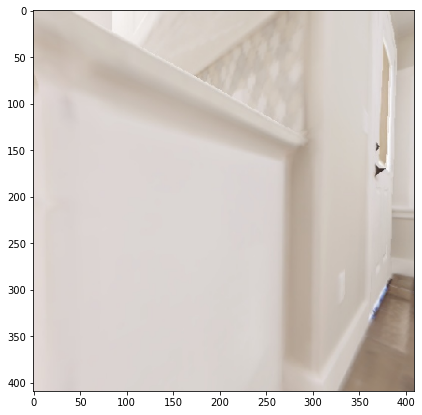

/home/locobotm/AVD/habitat_turk_data/04500.jpg


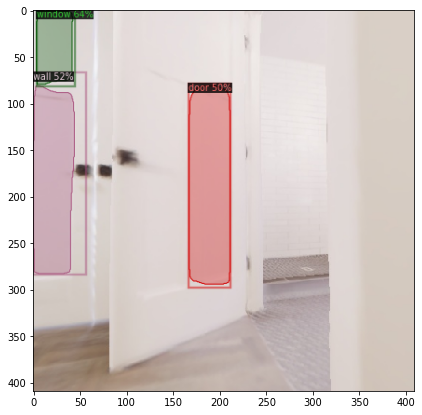

/home/locobotm/AVD/habitat_turk_data/04620.jpg


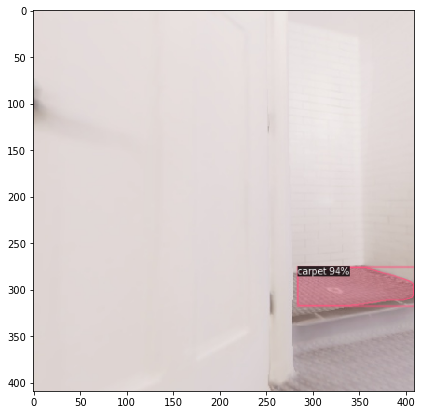

In [10]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = (val_data, )
predictor = DefaultPredictor(cfg)


def visualize(filename):
    im = cv2.imread(filename)
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=MetadataCatalog.get(val_data), 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(v.get_image())
    plt.show()

for d in DatasetCatalog.get(val_data):
    print(d['file_name'])
    visualize(d['file_name'])
